In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

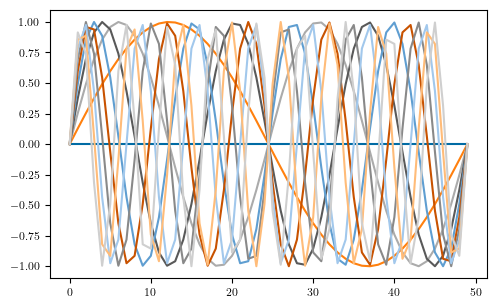

In [26]:
from os import path

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name):
    return path.join(FIGURES_PATH, f"{name}.pgf")

plt.style.use(["default", "tableau-colorblind10", "./thesis.mplstyle"])
plt.figure(figsize=figsize())
for i in range(10):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()



/home/oslund/.local/lib/python3.8/site-packages/opensimplex/opensimplex.py:62: RuntimeWarning: overflow encountered in long_scalars
  seed = overflow(seed * 6364136223846793005 + 1442695040888963407)


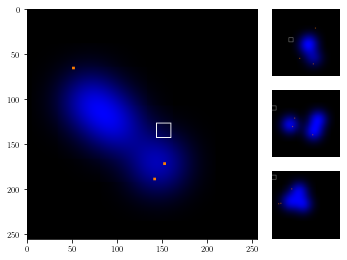

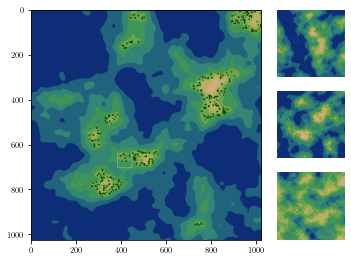

In [28]:
import gym
import gym_search


def plot_environment(env_id, seed=0, count=4, steps=10):
    layout = [
        [0, 0, 0, 1],
        [0, 0, 0, 2],
        [0, 0, 0, 3],
    ]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=0.75, subplots=(3,3)))

    env = gym.make(env_id)
    env.seed(seed)

    for i in range(count):
        env.reset()
        if i == 0:
            for _ in range(steps):
                env.step(env.action_space.sample())
    
        img = env.render(mode="rgb_array", show_view=True, show_targets=False, show_hits=False, show_path=False)

        axs[i].imshow(img)
        if i != 0:
            axs[i].set_axis_off()

    return fig

plot_environment("SearchGaussian-v0").savefig(figpath("gaussian"))
plot_environment("SearchTerrain-v0").savefig(figpath("terrain"))


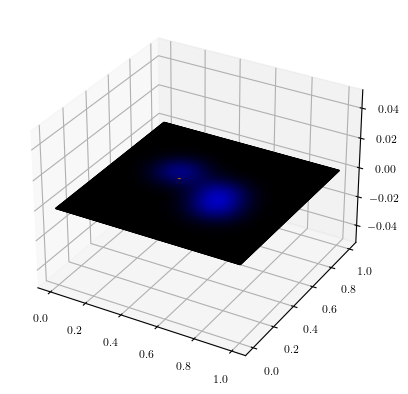

In [54]:
import gym
import gym_search

env = gym.make("SearchGaussian-v0")
obs = env.reset()
img = env.render(mode="rgb_array", show_view=False, show_targets=False, show_hits=False, show_path=False)

h, w, _c = img.shape

# https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272

fig = plt.figure()
ax = plt.axes(projection='3d')

#points = [(10, 20, 1), (4, 1, 3)]
#xs, ys, zs = zip(*points)
#ax.scatter(xs, ys, zs)
#ax.grid(False)

xx, yy = np.meshgrid(np.linspace(0, 1, h), np.linspace(0, 1, w))
zz = np.zeros((h, w))
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, facecolors=img/255)

#view = env.view
#ax.add_patch(mpl.patches.Rectangle(view.pos, *view.shape, linewidth=1, edgecolor="r"))

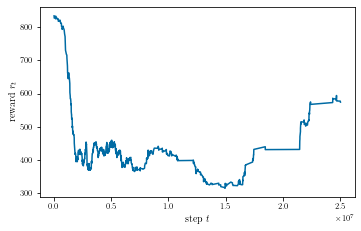

In [41]:
from scipy.ndimage import uniform_filter1d

def plot_tboard(csv_path, xlabel="step", ylabel="value", smooth=None):
    df = pd.read_csv(csv_path)
    fig, ax = plt.subplots(figsize=figsize())

    x = df["Step"]
    y = df["Value"]

    if smooth is not None:
        y = uniform_filter1d(y, size=smooth)

    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #return fig

plot_tboard("logs/run-2022-03-16T09 50 58.329003-tag-charts_episode_length.csv", xlabel="step $t$", ylabel="reward $r_t$", smooth=100)    